In [2]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

X = np.load("X_features.npy")  # MFCC features
y = np.load("y_labels.npy")  # Labels

In [3]:
# LDA Functions
def compute_class_means(X, y):
    class_labels = np.unique(y)
    means = {label: np.mean(X[y == label], axis=0) for label in class_labels}
    return means

def compute_within_class_scatter(X, y, means):
    n_features = X.shape[1]
    Sw = np.zeros((n_features, n_features))
    for label, mean in means.items():
        class_scatter = np.dot((X[y == label] - mean).T, (X[y == label] - mean))
        Sw += class_scatter
    return Sw

def compute_between_class_scatter(X, y, means):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    Sb = np.zeros((n_features, n_features))
    for label, mean in means.items():
        n_samples = X[y == label].shape[0]
        mean_diff = (mean - overall_mean).reshape(-1, 1)
        Sb += n_samples * np.dot(mean_diff, mean_diff.T)
    return Sb

def lda(X, y, num_components):
    means = compute_class_means(X, y)
    Sw = compute_within_class_scatter(X, y, means)
    Sb = compute_between_class_scatter(X, y, means)

    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw).dot(Sb))
    eigvals = eigvals.real  # Keep only the real parts
    eigvecs = eigvecs.real  # Keep only the real parts

    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]
    return eigvecs[:, :num_components]

def project_data(X, eigenvectors):
    return np.dot(X, eigenvectors)

In [4]:
# KNN function remains unchanged
def calDist(x, y, metric):
    x, y = np.array(x), np.array(y)
    if metric == 'euclidean':
        return round(math.sqrt(np.sum((x - y) ** 2)), 2)
    elif metric == "manhattan":
        return round(np.sum(np.abs(x - y)), 2)

def knn_predict(X_train, y_train, X_test, k=5, metric='euclidean'):
    predictions = []
    for test_point in X_test:
        distances = [calDist(test_point, train_point, metric) for train_point in X_train]
        k_neighbors = np.argsort(distances)[:k]
        k_labels = [y_train[i] for i in k_neighbors]
        predictions.append(Counter(k_labels).most_common(1)[0][0])
    return np.array(predictions)

In [6]:
# Applying LDA
num_components = len(np.unique(y)) - 1
# lda_eigenvectors = lda(X, y, num_components)
# X_lda = project_data(X, lda_eigenvectors)
X_lda = np.load("X_lda.npy")

In [7]:
# Splitting data (70-20-10 Train-Test-Val Split)
X_train, X_temp, y_train, y_temp = train_test_split(X_lda, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Running KNN
k = 5
metric = 'euclidean'
y_train_pred = knn_predict(X_train, y_train, X_train, k, metric)
y_test_pred = knn_predict(X_train, y_train, X_test, k, metric)
y_val_pred = knn_predict(X_train, y_train, X_val, k, metric)

# Accuracy Calculation
train_accuracy = np.mean(y_train_pred == y_train) * 100
test_accuracy = np.mean(y_test_pred == y_test) * 100
val_accuracy = np.mean(y_val_pred == y_val) * 100

Train Accuracy: 99.89%
Test Accuracy: 99.80%
Validation Accuracy: 100.00%
Number of features after LDA : 49


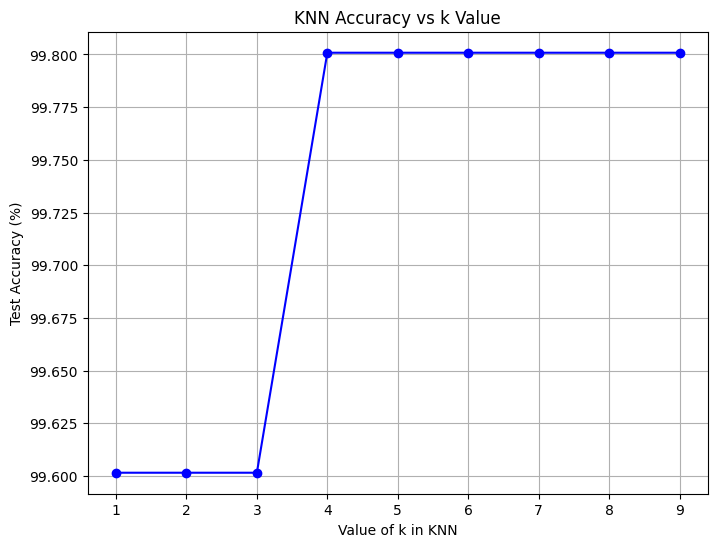

In [8]:
# Print Results
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Number of features after LDA : {X_lda.shape[1]}")

# Accuracy vs K plot
k_values = range(1, 10)
accuracies = []
for k in k_values:
    y_test_pred = knn_predict(X_train, y_train, X_test, k, metric)
    accuracies.append(np.mean(y_test_pred == y_test) * 100)

plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("Value of k in KNN")
plt.ylabel("Test Accuracy (%)")
plt.title("KNN Accuracy vs k Value")
plt.grid(True)
plt.show()